## Import packages

In [1]:
import numpy as np
from skimage.io import imread, imshow

## Import image

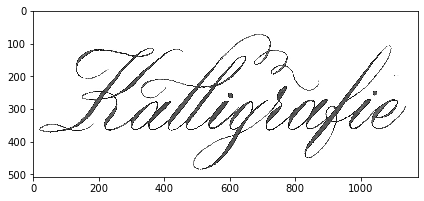

In [2]:
scan = imread('test-files/kalligrafie.png', as_gray=True)
imshow(scan)

## Convert image to binary

In [3]:
import matplotlib.pyplot as plt
import numpy as np
#plt.hist(scan)
#plt.show()

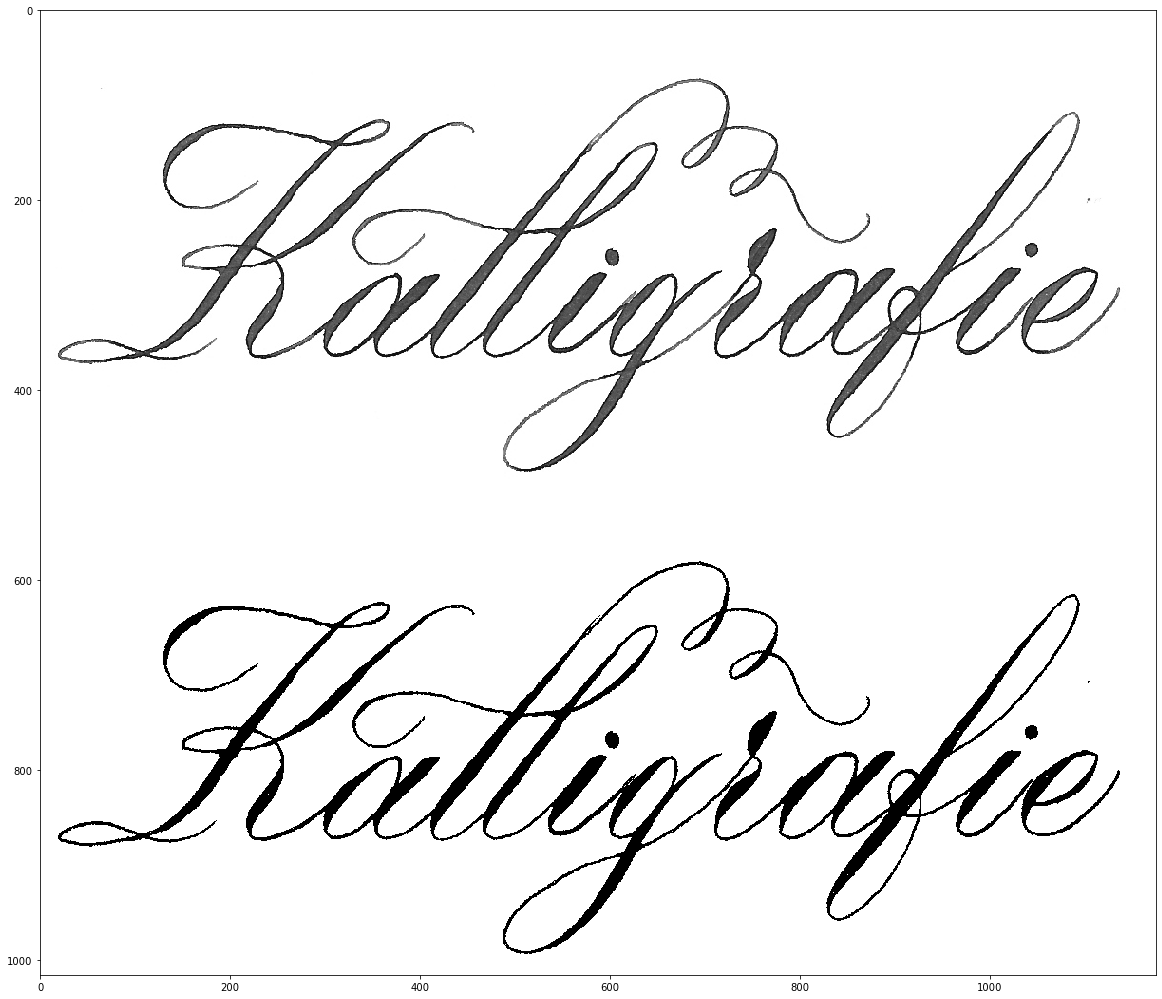

In [4]:
from skimage.filters import threshold_otsu

#threshold = 0.7
threshold = threshold_otsu(scan)

binary = scan > threshold
both = np.vstack((scan, binary))
plt.figure(figsize=(20, 20))
plt.imshow(both, cmap='gray', interpolation='nearest')

## Remove islands

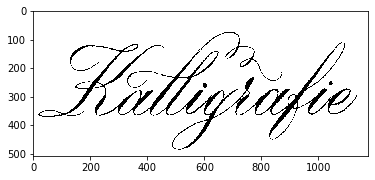

In [5]:
import skimage.morphology as mrp

footprint = np.array([
    [1, 1, 0],
    [1, 1, 1],
    [0, 1, 1]
])
footprint = np.array([
    [1, 1],
    [1, 1]
])

cleaned_image = mrp.remove_small_holes(binary)
cleaned_image = mrp.remove_small_objects(cleaned_image)

plt.imshow(cleaned_image, cmap='gray', interpolation='nearest')

## Contour tracing

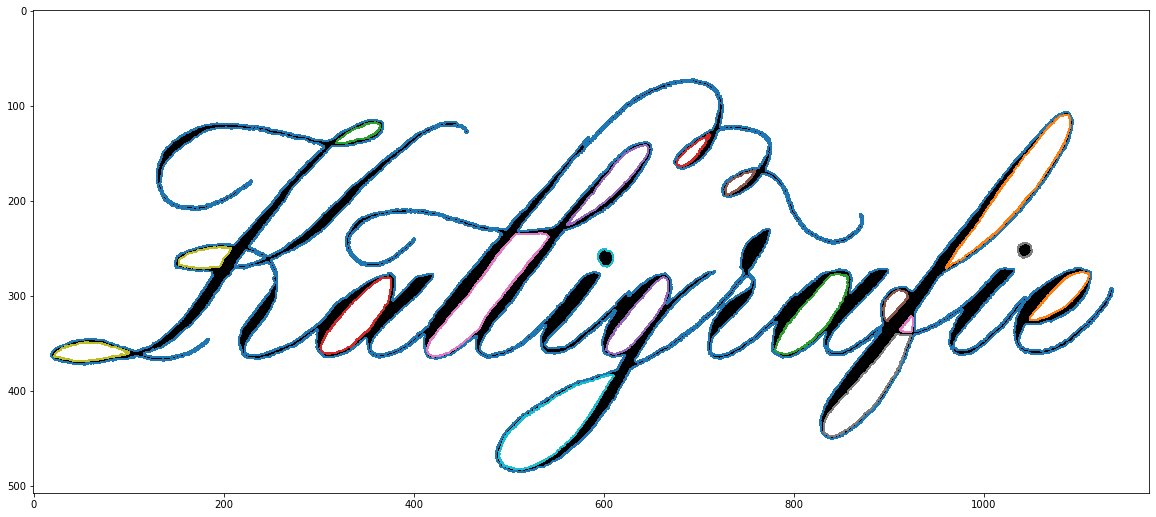

In [6]:
from skimage import measure

contours = measure.find_contours(cleaned_image)

# Display the image and plot all contours found
plt.rcParams['figure.figsize'] = (20, 20)

fig, ax = plt.subplots()
ax.imshow(cleaned_image, cmap='gray', interpolation='nearest')

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1, antialiased=False)

plt.show()

In [7]:
contours[7]

array([[ 260. , 1042.5],
       [ 259.5, 1043. ],
       [ 259.5, 1044. ],
       [ 259.5, 1045. ],
       [ 259. , 1045.5],
       [ 258.5, 1046. ],
       [ 258.5, 1047. ],
       [ 258. , 1047.5],
       [ 257.5, 1048. ],
       [ 257. , 1048.5],
       [ 256.5, 1049. ],
       [ 256. , 1049.5],
       [ 255. , 1049.5],
       [ 254.5, 1050. ],
       [ 254. , 1050.5],
       [ 253. , 1050.5],
       [ 252. , 1050.5],
       [ 251. , 1050.5],
       [ 250.5, 1050. ],
       [ 250. , 1049.5],
       [ 249. , 1049.5],
       [ 248. , 1049.5],
       [ 247. , 1049.5],
       [ 246.5, 1049. ],
       [ 246. , 1048.5],
       [ 245.5, 1048. ],
       [ 245.5, 1047. ],
       [ 245. , 1046.5],
       [ 244.5, 1046. ],
       [ 244.5, 1045. ],
       [ 244.5, 1044. ],
       [ 244.5, 1043. ],
       [ 244.5, 1042. ],
       [ 245. , 1041.5],
       [ 245.5, 1041. ],
       [ 245.5, 1040. ],
       [ 246. , 1039.5],
       [ 246.5, 1039. ],
       [ 246.5, 1038. ],
       [ 247. , 1037.5],


In [8]:
for contour in contours:
    print(len(contour))

14117
587
139
137
341
117
521
61
165
69
99
225
331
315
293
117
61
403
215
443


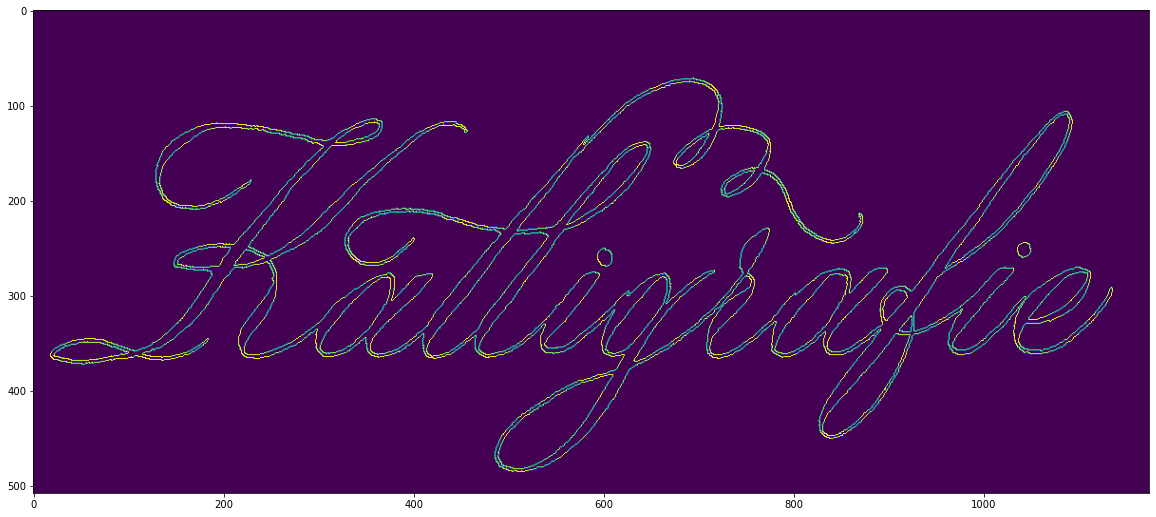

In [9]:
# Convert coordinates to image
contour_img = np.ma.array(np.zeros(np.shape(cleaned_image)))
for contour in contours:
    for pixel in np.int32(contour):
        contour_img[pixel[0], pixel[1]] = 1

plt.imshow(contour_img)

## Corner detection

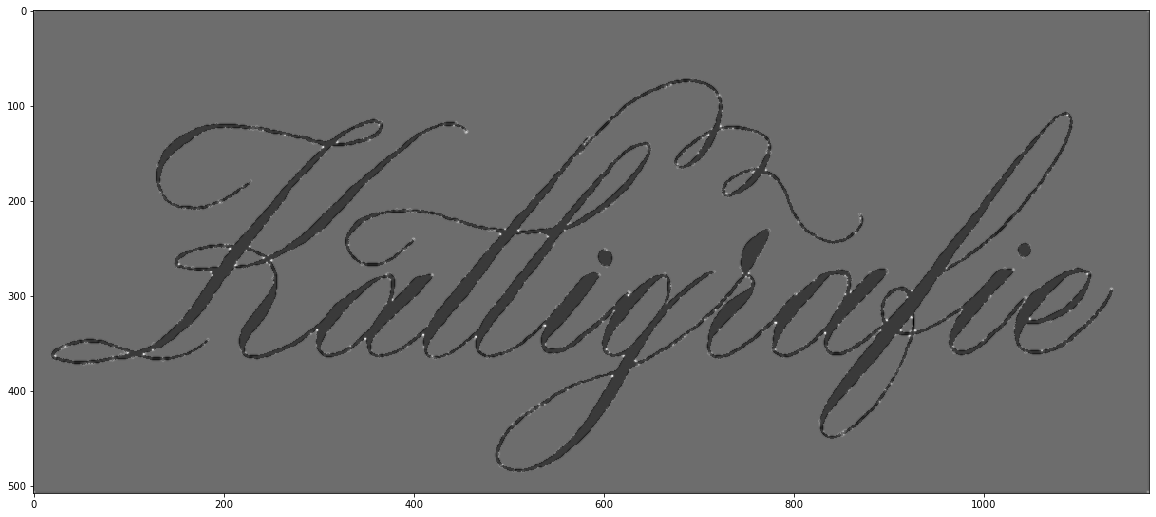

In [10]:
from skimage.feature import corner_harris, corner_subpix, corner_peaks

corners = corner_harris(cleaned_image)

fig, ax = plt.subplots()
ax.imshow(cleaned_image, cmap=plt.cm.gray, interpolation='nearest')
ax.imshow(corners, interpolation='nearest', cmap='gray', alpha=0.8)
plt.show()

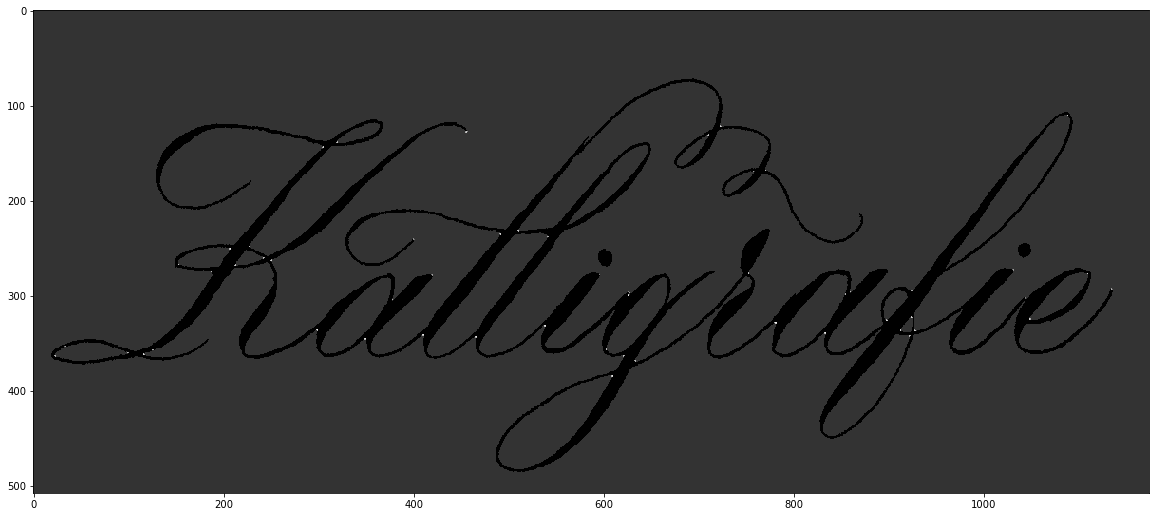

In [11]:
corners[corners < 15] = 0

fig, ax = plt.subplots()
ax.imshow(cleaned_image, cmap=plt.cm.gray, interpolation='nearest')
ax.imshow(corners, interpolation='nearest', cmap='gray', alpha=0.8)
plt.show()

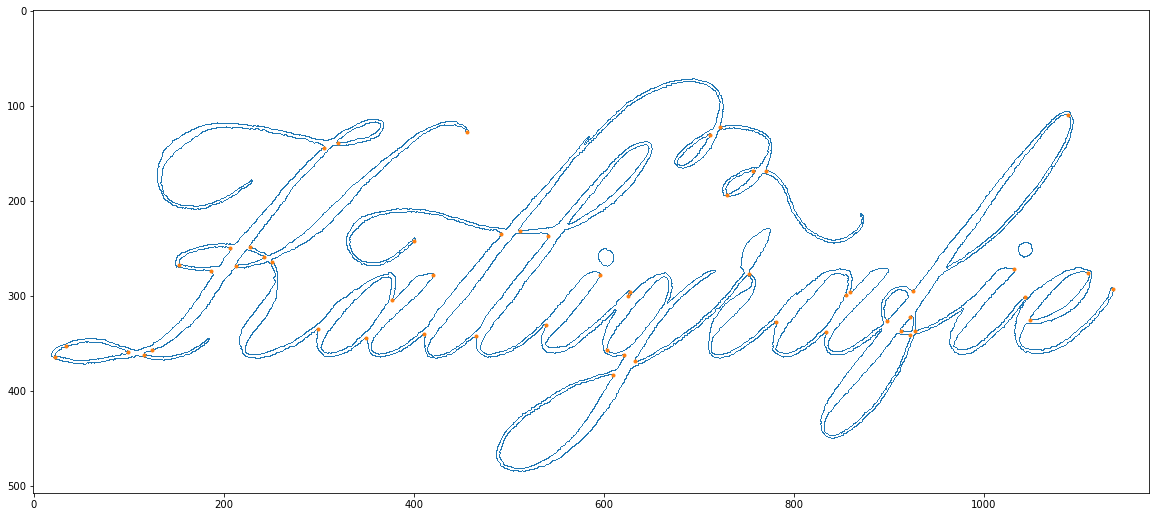

In [12]:
from skimage.feature import peak_local_max

corner_coords = peak_local_max(corners)

x_vals=[]
y_vals=[]
for c in contours:
    for x in c[:,1]:
        x_vals.append(x)
    for y in c[:,0]:
        y_vals.append(y)

all_contours = np.array([y_vals,x_vals])
#print(np.shape(all_contours))
#print(all_contours)

# Move coordinates onto contour
corrected_corners = []
for coord in corner_coords:
    distances = np.sqrt((all_contours[0] - coord[0]) ** 2 + (all_contours[1] - coord[1]) ** 2)
    corrected_corners.append(all_contours[:,np.argmin(distances)])

corrected_corners = np.array(corrected_corners)

fig, ax = plt.subplots()
ax.imshow(contour_img, alpha=0) # for shape of plot
ax.plot(all_contours[1], all_contours[0], linestyle='none', marker=',')
ax.plot(corrected_corners[:, 1], corrected_corners[:, 0], antialiased=False, marker='.', linestyle='none')
plt.show()

## Split by corners

In [13]:
def split_contour_by_corners(contour, corners):
    segments = []
    first_segmentation_index = np.nan
    last_segmentation_index = 0
    for i, pixel in enumerate(contour):
        for j, corner in enumerate(corners):
            #print(corner[0], pixel[0], corner[1], pixel[1])
            if corner[0] == pixel[0] and corner[1] == pixel[1]:
                new_row = contour[last_segmentation_index:(i + 1)]
                segments.append(new_row)
                last_segmentation_index = i
                if first_segmentation_index == np.nan:
                    first_segmentation_index = i

    if len(segments) > 1 and first_segmentation_index != 0:
        new_row = list(contour[last_segmentation_index:len(contour)-1]) + list(segments[0])
        segments.append(new_row)
        segments.pop(0)
    else:
        new_row = contour[last_segmentation_index:len(contour)]
        segments.append(new_row)
    return segments


contours_in_segments = []
for contour in contours:
    contours_in_segments.append(split_contour_by_corners(contour, corrected_corners))


#contours_in_segments

#for contour in contours_in_segments:
#    for segment in contour:
#        print(segment)
#        points = np.array([segment[:,0], np.flipud(segment[:,1])])
#        print(points)

## Curve fitting
https://github.com/volkerp/fitCurves

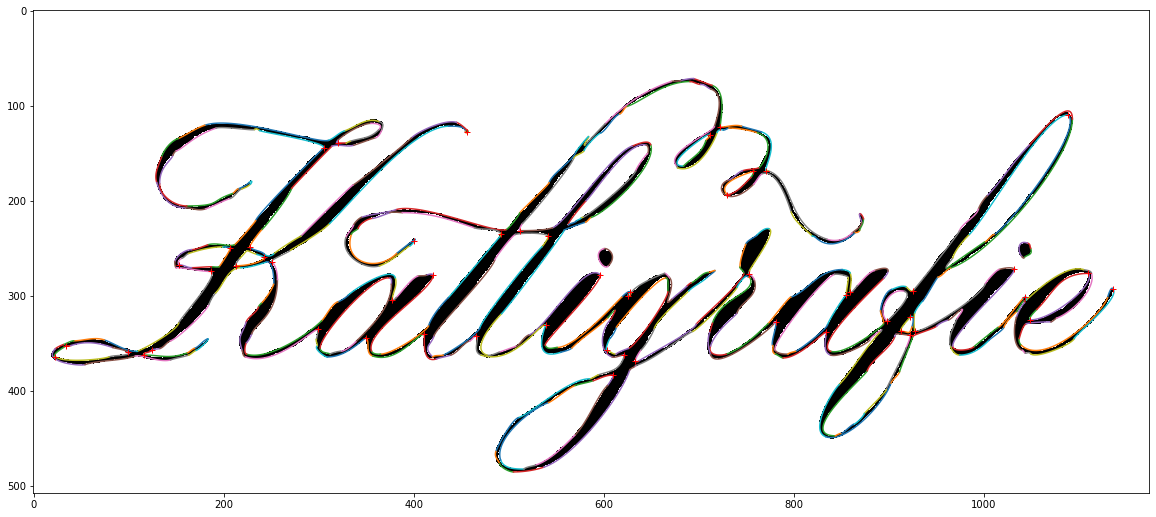

In [14]:
from bezier import *
from fitCurves import *

maxError = 3
# Also added in library option to choose
splitError = 30
minIterationsBeforeSplit = 10

fig, ax = plt.subplots()
ax.imshow(cleaned_image, cmap=plt.cm.gray, interpolation='nearest')

# Prepare SVG
#import svgwrite
#dwg = svgwrite.Drawing('test-files/test.svg', size=np.shape(cleaned_image)[::-1], profile='tiny')
from libraries import SVG

svg_file = SVG.create_file('test-files/test.svg', np.shape(cleaned_image)[1], np.shape(cleaned_image)[0])
path_string = '\n'

for contour in contours_in_segments:
    svg_path = ''

    for i, segment in enumerate(contour):
        points = segment
        #print(points)

        beziers = fitCurve(points, maxError, splitError, minIterationsBeforeSplit)
        #print(beziers)

        for j, bez in enumerate(beziers):
            bez = np.stack(bez)
            bez = np.round(bez, 2)

            # Build SVG path
            if i == 0 and j == 0:
                svg_path = 'M{x0},{y0} C{x1},{y1}, {x2},{y2}, {x3},{y3}'.format(
                    x0=bez[0, 1],
                    y0=bez[0, 0],
                    x1=bez[1, 1],
                    y1=bez[1, 0],
                    x2=bez[2, 1],
                    y2=bez[2, 0],
                    x3=bez[3, 1],
                    y3=bez[3, 0]
                )
            else:
                svg_path += ', {x1},{y1}, {x2},{y2}, {x3},{y3}'.format(
                    x1=bez[1, 1],
                    y1=bez[1, 0],
                    x2=bez[2, 1],
                    y2=bez[2, 0],
                    x3=bez[3, 1],
                    y3=bez[3, 0]
                )

            curve = []
            for t in np.linspace(0, 1, 50):
                curve.append(bezier.q(bez, t))

            curve = np.stack(curve)
            ax.plot(curve[:, 1], curve[:, 0])

    path_string += f'{svg_path}Z\n'


ax.plot(corrected_corners[:, 1], corrected_corners[:, 0], 'r+')


plt.savefig('test-files/modFitCurves.png', dpi=1200)
SVG.add_path_element(svg_file, path_string)
SVG.save_file(svg_file)